In [85]:
# 불용어 목록 선언
stopwords = list(set([
    '이', '가', '은', '는', '을', '를', '의', '에', '에서', '에게', '께', '로', '으로', 
    '와', '과', '보다', '처럼', '만큼', '같이', '까지', '마저', '조차', '부터', 
    '이나', '나', '이며', '며', '등', '하다', '한다', '하고', '하니', '하면', 
    '되어', '되다', '되고', '되니', '입니다', '습니다', 'ㅂ니다', '어요', '아요', '다',
    '고', '면', '게', '지', '죠',
    '그리고', '그러나', '하지만', '그런데', '그래서', '그러면', '그러므로', '따라서', 
    '또한', '또는', '및', '즉', '한편', '반면에', '근데',
    '나', '저', '우리', '저희', '너', '너희', '당신', '그', '그녀', '그들', '누구',
    '무엇', '어디', '언제', '어느', '이것', '그것', '저것', '여기', '거기', '저기', 
    '이쪽', '그쪽', '저쪽',
    '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열',
    '일', '이', '삼', '사', '오', '육', '칠', '팔', '구', '십', '백', '천', '만',
    '첫째', '둘째', '셋째',
    '바로', '때', '것', '수', '문제', '경우', '부분', '이다',
    '내용', '결과', '자체', '가지', '있다',
    '않았어요', '있었어요', '했어요', '했는데요', '있는데요', '합니다', '없다', '나다','생각하다',
    '했다', '같다', '네요','아니다', '용하다', '물이',
    '뿐', '대로', '만', '따름', '김에', '터',
    '아', '아이고', '아이구', '아하', '어', '그래', '응', '네', '예', '아니', '않다', '안되다','안',
    '가다', '오다', '주다', '말다', '나다', '받다', '알다', '모르다', '싶다', '생각하다', '들다'
]))
stopwords = set(stopwords)

In [86]:
import pickle
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def clean_text(text):
    text = re.sub(r"[^가-힣0-9\s]", "", str(text))
    return ' '.join(text.split())

# 데이터 로드
train_df = pd.read_csv("ratings_train_data.csv")
test_df = pd.read_csv("ratings_test_data.csv")

# 전처리
train_df['review_content'] = train_df['review_content'].astype(str).apply(clean_text)
test_df['review_content'] = test_df['review_content'].astype(str).apply(clean_text)

# 텍스트 리스트
X_train = train_df['review_content'].tolist()
X_test = test_df['review_content'].tolist()

# 라벨 리스트
y_train = train_df['label'].astype(np.int32).values
y_test = test_df['label'].astype(np.int32).values

# 4. 토크나이저 학습 및 정수 인코딩
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 5. 길이 제한 후 다시 쌍 정렬
def trim_samples(X, y, max_len):
    X_out, y_out = [], []
    for x, label in zip(X, y):
        if len(x) <= max_len:
            X_out.append(x)
            y_out.append(label)
    return X_out, y_out


# 시퀀스 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 6. 패딩
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post', dtype='int32')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post', dtype='int32')

# 7. 결과 확인
print("X_train:", X_train_pad.shape, "y_train:", len(y_train))
print("X_test:", X_test_pad.shape, "y_test:", len(y_test))


X_train: (9600, 100) y_train: 9600
X_test: (2400, 100) y_test: 2400


In [87]:
# 8. 저장
with open('X_train_final.pickle', 'wb') as f:
    pickle.dump(X_train_pad, f)
with open('X_test_final.pickle', 'wb') as f:
    pickle.dump(X_test_pad, f)
with open('y_train_final.pickle', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test_final.pickle', 'wb') as f:
    pickle.dump(y_test, f)

In [90]:
print(type(y_train))
y_train = train_df['label'].astype(np.int32).values

<class 'numpy.ndarray'>


In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import os
import time
import csv
from tensorflow.keras.callbacks import CSVLogger

input_dim = 10000
embedding_dim = 64
learning_rate = 1e-4
max_len = 100
hidden_units = 32

# 실험 이름 정의 (날짜/시간 + 주요 하이퍼파라미터)
timestamp = time.strftime('%Y%m%d-%H%M%S')
experiment_name = f"exp_{timestamp}_lr{learning_rate}_bs64_lstm64"

# 디렉토리 생성
log_dir = f"./logs/{experiment_name}"
os.makedirs(log_dir, exist_ok=True)

# CSVLogger: epoch마다 val_acc, loss 등 기록
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))

# EarlyStopping & ModelCheckpoint (같이 사용)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = ModelCheckpoint(os.path.join(log_dir, 'best_model.h5'),
                     monitor='val_accuracy', save_best_only=True, verbose=1)

# 모델 구성
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_len),
    LSTM(hidden_units),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


# 컴파일
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

BATCH_SIZE = 128


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))

# 훈련
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[es, mc, csv_logger],
    class_weight=class_weights
)


# history 결과에서 마지막 성능 요약 저장
final_log_path = os.path.join(log_dir, 'summary.csv')
with open(final_log_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['param', 'value'])
    writer.writerow(['timestamp', timestamp])
    writer.writerow(['embedding_dim', embedding_dim])
    writer.writerow(['lstm_units', hidden_units])
    writer.writerow(['learning_rate', learning_rate])
    writer.writerow(['batch_size', BATCH_SIZE])
    writer.writerow(['max_len', max_len])
    writer.writerow(['val_accuracy_last', history.history['val_accuracy'][-1]])
    writer.writerow(['val_loss_last', history.history['val_loss'][-1]])

final_model_path = os.path.join(log_dir, 'final_model.keras')
model.save(final_model_path)

Epoch 1/10
59/60 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.4964
Epoch 1: val_accuracy improved from -inf to 0.52917, saving model to ./logs/exp_20250715-141612_lr0.0001_bs64_lstm64\best_model.h5
60/60 [==============================] - 5s 55ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6926 - val_accuracy: 0.5292
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5147
Epoch 2: val_accuracy improved from 0.52917 to 0.53177, saving model to ./logs/exp_20250715-141612_lr0.0001_bs64_lstm64\best_model.h5
60/60 [==============================] - 3s 54ms/step - loss: 0.6927 - accuracy: 0.5147 - val_loss: 0.6923 - val_accuracy: 0.5318
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5288
Epoch 3: val_accuracy improved from 0.53177 to 0.53438, saving model to ./logs/exp_20250715-141612_lr0.0001_bs64_lstm64\best_model.h5
60/60 [==============================] - 3s 50ms/step - los

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from matplotlib import font_manager as fm
from konlpy.tag import Okt
okt = Okt()

# ✅ 폰트 설정
font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# ✅ 학습 그래프 시각화
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_plot.png')
    plt.show()

def preprocess_for_training(text, stopwords):
    tokens = okt.morphs(text)
    return [t for t in tokens if t not in stopwords]

# 2. 키워드 추출용 (pos + 명사만 + 2글자 이상)
def extract_keywords_by_pos(X, y, sentiment_label, top_k=100, allowed_tags=['Adjective', 'Noun']):
    counter = Counter()
    for sentence, label in tqdm(zip(X, y), total=len(X)):
        if label == sentiment_label:
            tagged = okt.pos(sentence)
            filtered = [word for word, tag in tagged if tag in allowed_tags and len(word) >= 2]
            counter.update(filtered)
    return counter.most_common(top_k)

# ✅ 예측 함수
def predict_sentiment(text, tokenizer, model, stopwords, max_len=100):
    filtered = preprocess_for_training(text, stopwords)
    sequence = tokenizer.texts_to_sequences([' '.join(filtered)])
    padded = pad_sequences(sequence, maxlen=max_len)
    prob = model.predict(padded)[0][0]
    label = '긍정' if prob > 0.5 else '부정'
    return label, prob

# ✅ 워드클라우드 생성
def generate_wordcloud(texts, font_path, output_path='wordcloud.png'):
    text = ' '.join(texts)
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=400
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# ✅ 감성 키워드 추출 (label=1: 긍정, 0: 부정)
# def extract_keywords_by_sentiment(X, y, sentiment_label=1, top_k=100):
#     keyword_counter = Counter()
#     for sentence, label in tqdm(zip(X, y), total=len(X)):
#         if label == sentiment_label:
#             words = [word for word in sentence.split() if len(word) >= 2]
#             keyword_counter.update(words)
#     return keyword_counter.most_common(top_k)

# ✅ 감성 키워드 바 차트 시각화
def plot_top_keywords(keyword_list, title, font_prop, color='red'):
    words, freqs = zip(*keyword_list[:20])
    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], freqs[::-1], color=color)
    plt.title(title, fontproperties=font_prop)
    plt.xlabel('빈도수')
    plt.tight_layout()
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

print("✅ 전체 기능 완성: 모델 저장, 학습 시각화, 예측, 워드클라우드, 키워드 시각화")


✅ 전체 기능 완성: 모델 저장, 학습 시각화, 예측, 워드클라우드, 키워드 시각화


In [93]:
results = []

for text in X_test:
    label, prob = predict_sentiment(text, tokenizer, model, stopwords)
    results.append({
        '리뷰': text,
        '예측': label,
        '확률': round(prob, 4)
    })

import pandas as pd
df_result = pd.DataFrame(results)
df_result.to_csv("LSTM_감성예측결과.csv", encoding="utf-8-sig", index=False)

1/1 [==============================] - 0s 20ms/step


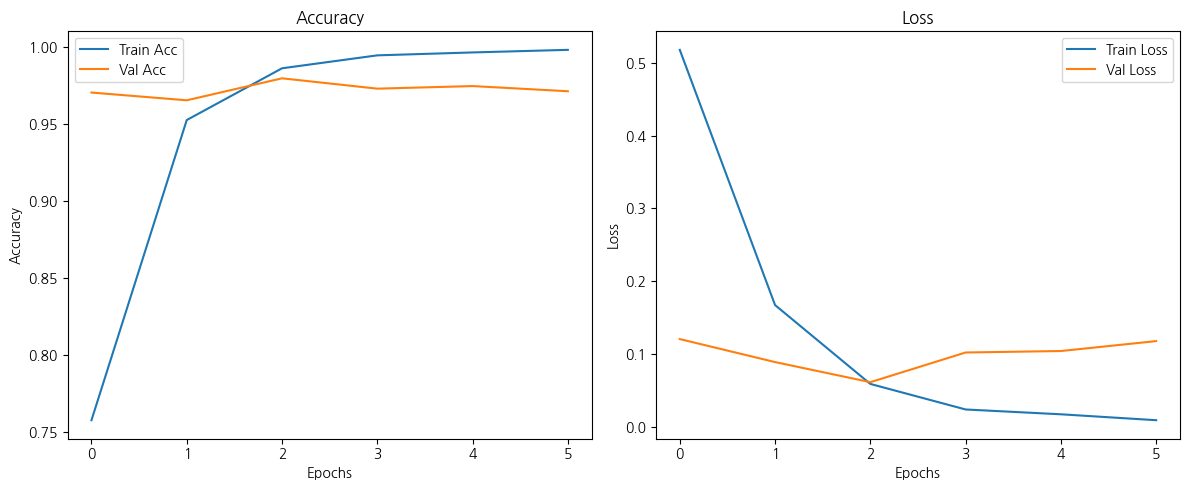

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 5944/6138 [00:47<00:01, 124.62it/s]


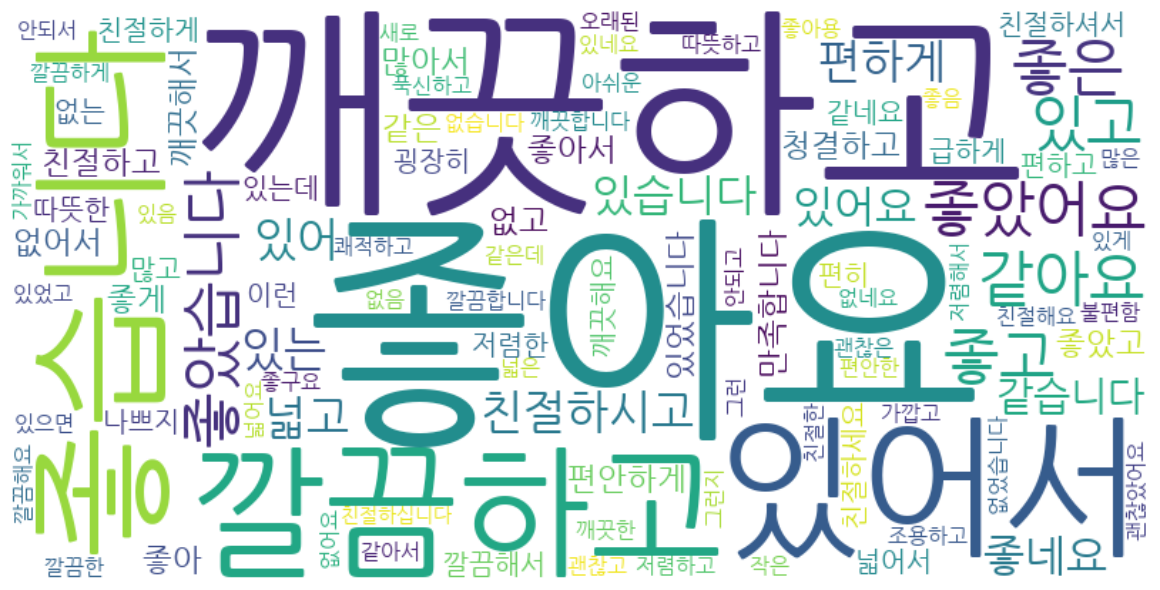

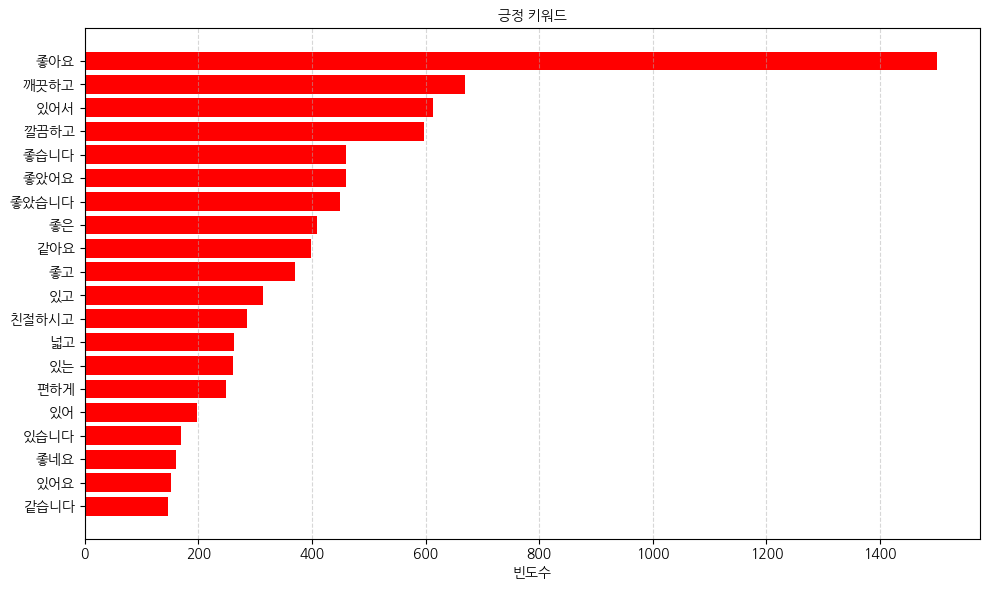

 97%|█████████▋| 5944/6138 [00:11<00:00, 504.63it/s] 


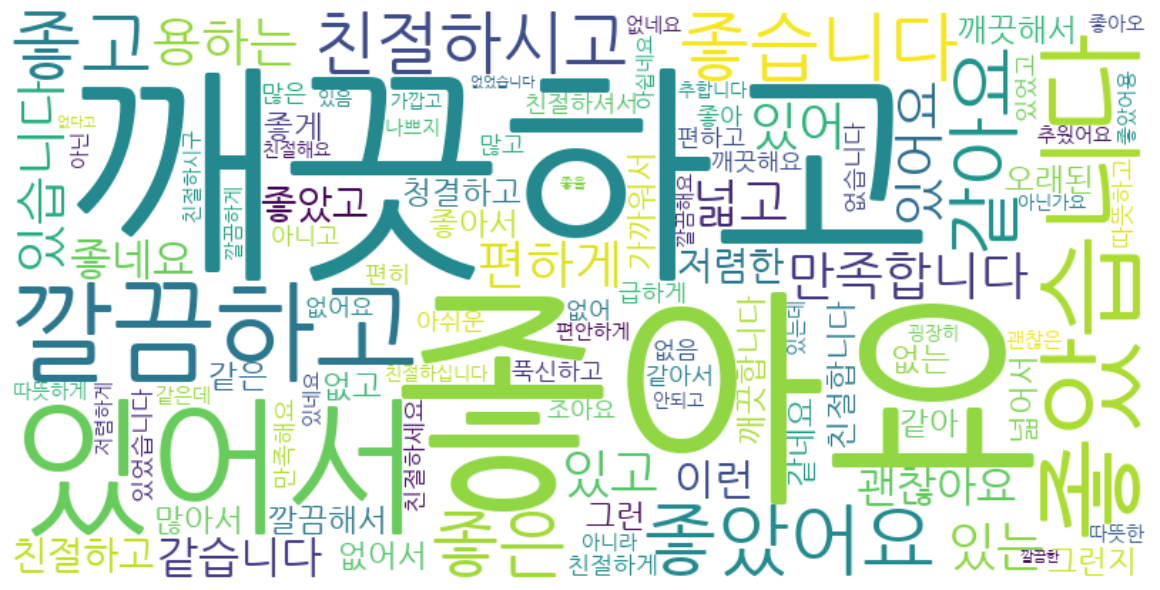

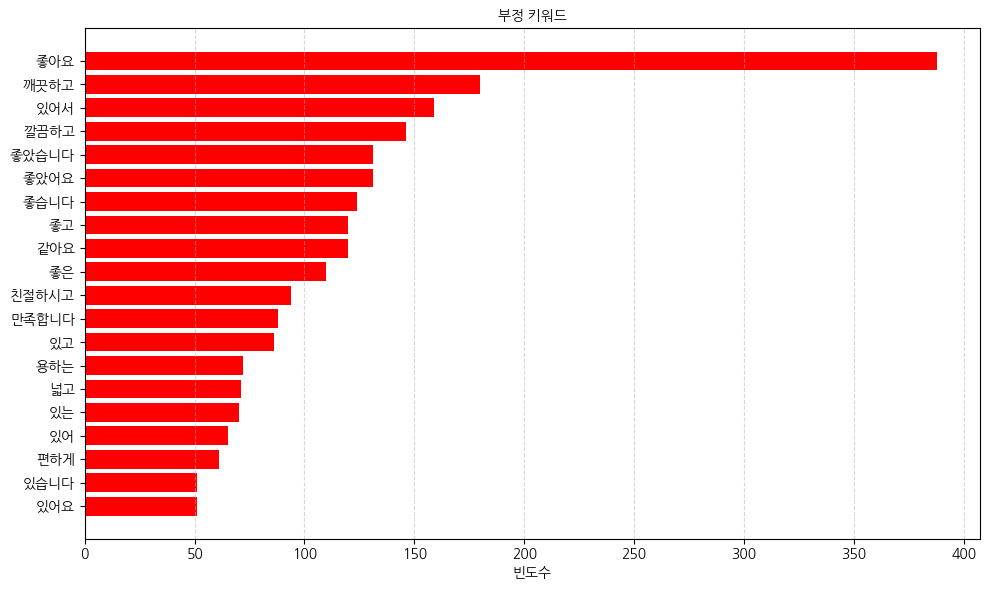

In [ ]:
# 학습 그래프
plot_history(history)

# 예측 예시
predict_sentiment(X_test, tokenizer, model, stopwords)

# 긍정 키워드
pos_keywords = extract_keywords_by_pos(X_train, y_train, sentiment_label=1)
generate_wordcloud([' '.join([k for k, _ in pos_keywords])], font_path, 'pos_wc.png')
plot_top_keywords(pos_keywords, "긍정 키워드", font_prop)

# 부정 키워드
neg_keywords = extract_keywords_by_pos(X_train, y_train, sentiment_label=0)
generate_wordcloud([' '.join([k for k, _ in neg_keywords])], font_path, 'neg_wc.png')
plot_top_keywords(neg_keywords, "부정 키워드", font_prop)
